In [1]:
# ================================================================================================================
# Figure 6: Extreme rainfall event in a selected model year (Rx1d) over southern South Island (Southland Region)
# Purpose: Visualize a single extreme rainfall event, its synoptic context, and its position within the local
#          Rx1d distribution.
# Inputs: Weather@Home Rx1d dataset, 10m wind, Mean Sea Level Pressure (MSLP), and Total Column Water (TCW)
#         for the selected model year.
# Outputs:
#   (a) Map of daily rainfall totals with grid cells exceeding threshold highlighted.
#   (b) Synoptic map showing MSLP, TCW, and 10m wind vectors.
#   (c) Histogram of Rx1d values for the selected grid cells, highlighting the selected event.
# ================================================================================================================

In [2]:
# ---------------------------------------------------------------
# Section 1: Import required libraries
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as stats
import pandas as pd
import glob
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Set default plot font for consistency
plt.rcParams["font.family"] = "Arial"

-------

In [3]:
# ---------------------------------------------------------------
# Section 2: Prepare rainfall data for Panel a
# ---------------------------------------------------------------

# Select model-year (Unified Model ID)
selected_umid = 'a1az'

# Load daily rainfall data for the selected model-year
rainfall = xr.open_dataset(glob.glob(f'../Weather@home Data/current_decade/item5216_daily_mean_{selected_umid}_*.nc')[0])['item5216_daily_mean'][:,0,:,:]

# Define the date of the simulated event
day, month, year = str(23), str(3), str(2011)

# Find index of the selected event
index_for_selected_event = np.where([(t.year == int(year) and t.month == int(month) and t.day == int(day)) for t in rainfall['time1'].values])[0][0] # Index of the selected simulated event

# Extract rainfall for the selected event
selected_rainfall = rainfall[index_for_selected_event,:,:].copy()

# Apply land-sea mask to remove ocean values
land_sea_mask = pd.read_excel('../Weather@home Data/Land-Sea Mask for Weather@home Data.xlsx').T # File to mask the surrounding ocean
selected_rainfall.data = np.where(np.isnan(land_sea_mask), np.nan, selected_rainfall)

--------

In [4]:
# ---------------------------------------------------------------
# Section 3: Prepare synoptic data for Panel b
# ---------------------------------------------------------------

# Load 10m wind components, wind speed, MSLP (Mean Sea Level Pressure), specific humidity, and surface air pressure
wind_u = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field48'][:,0,:,:]
wind_v = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field49'][:,0,:,:]
wind_speed = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field50'][:,0,:,:]
mslp = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field8'][:,0,:,:] / 100 # Convert to hPa
specific_humidity = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field95'][:,0,:,:]
surface_air_pressure = xr.open_dataset(glob.glob('../Weather@home Data/Synoptic Data/' + selected_umid + '/*.nc')[0])['field8_1'][:,0,:,:]

# ----------------------------------------------------------------------------------------------------------------

# Calculate Total Column Water (TCW) in kg/m²
# TCW formula: TCW = (Column-integrated specific humidity (kg/kg) * Surface Air Pressure (Pa)) / Gravity (9.81 m/s²)
tcw = (specific_humidity * surface_air_pressure) / 9.81

# ----------------------------------------------------------------------------------------------------------------

# Mask MSLP, TCW, and wind fields to the region of interest (150E–170W, 60–10S)
masked_mslp = mslp.where(~((mslp.global_longitude0 < 150) | (mslp.global_longitude0 > 190)) | ((mslp.global_latitude0 < -60) | (mslp.global_latitude0 > -10)), drop=True)
masked_tcw = tcw.where(~((tcw.global_longitude0 < 150) | (tcw.global_longitude0 > 190)) | ((tcw.global_latitude0 < -60) | (tcw.global_latitude0 > -10)), drop=True)
masked_wind_u = wind_u.where(~((wind_u.global_longitude1 < 150) | (wind_u.global_longitude1 > 190)) | ((wind_u.global_latitude1 < -60) | (wind_u.global_latitude1 > -10)), drop=True)
masked_wind_v = wind_v.where(~((wind_v.global_longitude1 < 150) | (wind_v.global_longitude1 > 190)) | ((wind_v.global_latitude1 < -60) | (wind_v.global_latitude1 > -10)), drop=True)
masked_wind_speed = wind_speed.where(~((wind_speed.global_longitude1 < 150) | (wind_speed.global_longitude1 > 190)) | ((wind_speed.global_latitude1 < -60) | (wind_speed.global_latitude1 > -10)), drop=True)

# Select data for the chosen event date
selected_mslp = masked_mslp[int(day)-1,:,:]
selected_tcw = masked_tcw[int(day)-1,:,:]
selected_wind_u = masked_wind_u[int(day)-1, :, :]
selected_wind_v = masked_wind_v[int(day)-1, :, :]
selected_wind_speed = masked_wind_speed[int(day)-1, :, :]

---------

In [5]:
# ---------------------------------------------------------------
# Section 4: Prepare data for Panel c (event Rx1d over selected grid cells)
# ---------------------------------------------------------------

# Read file list of all daily rainfall datasets
with open("../../Weather@home/Weather@home Data/File_List_Weather@home_Data_Stationary_Climate.txt", "r") as f:
    file_list_of_all_daily_rainfall_data = [line.strip() for line in f]  # Remove any extra spaces or newlines
file_list_of_all_daily_rainfall_data = ["../Weather@home Data/current_decade/" + filename_stationary for filename_stationary in file_list_of_all_daily_rainfall_data]

# Load all rainfall data
all_daily_rainfall_data = xr.open_mfdataset(file_list_of_all_daily_rainfall_data, combine='nested', concat_dim="time1")['item5216_daily_mean'][:,0,:,:]

# Assign year and day coordinates for each timestep
n_time = all_daily_rainfall_data.sizes["time1"]  # Number of time steps
n_years = n_time // 360  # Number of years (360 days per year)
new_time = np.arange(1, n_time + 1)  # Time steps: 1, 2, ..., n_time
years = (new_time - 1) // 360 + 1  # Assign year (1, 2, 3,...)
days = (new_time - 1) % 360 + 1  # Assign day within the year (1-360)
all_daily_rainfall_data = all_daily_rainfall_data.assign_coords(year=("time1", years), day=("time1", days))


# Recalculate Rx1d across grid cells exceeding specified rainfall threshold

# Select grid cells exceeding specified rainfall threshold
select_rainfall_threshold = 100 # 100 mm/day is defined and chosen to highlight the extreme rainfall event
daily_rainfall_data_of_specified_grid_cells = np.array(all_daily_rainfall_data)[:, np.where(selected_rainfall > select_rainfall_threshold)[0], 
                                                                                np.where(selected_rainfall > select_rainfall_threshold)[1]]

# Compute spatial average across selected grid cells for the daily rainfall data
average_daily_rainfall_data_of_specified_grid_cells = np.nanmean(daily_rainfall_data_of_specified_grid_cells, axis=(1))
    
# Convert the array to an xarray DataArray
average_daily_rainfall_data_of_specified_grid_cells_xarray = xr.DataArray(average_daily_rainfall_data_of_specified_grid_cells, 
                                                                          coords={"time1": all_daily_rainfall_data.time1,
                                                                                  "year": all_daily_rainfall_data.year,
                                                                                  "day": all_daily_rainfall_data.day
                                                                                 }, dims=["time1"])

# Calculate the maximum daily rainfall (Rx1d) for each year
rx1d_of_specified_grid_cells = np.array(average_daily_rainfall_data_of_specified_grid_cells_xarray.groupby("year").max("time1"))
rx1d_of_specified_grid_cells_df = pd.DataFrame({'a1az': rx1d_of_specified_grid_cells}) # Convert Rx1d Array to Dataframe

--------

In [6]:
# ---------------------------------------------------------------
# Section 5: Gridline function for Panel a
# ---------------------------------------------------------------

def setup_gridlines(ax):
    # Configure gridlines, tick marks, and label formatting for Cartopy maps
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.05, linestyle='--', draw_labels=False)

    # Configure tick marks for both axes
    ax.tick_params(axis='both', which='both', direction='out', length=5, width=1, labelsize=14)
    ax.set_xticks(np.arange(160, 180, 2), crs=ccrs.PlateCarree())  # Longitude ticks
    ax.set_yticks(np.arange(-50, -30, 2), crs=ccrs.PlateCarree())  # Latitude ticks
    
    # Format longitude and latitude labels
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    
    # Ensure ticks are drawn on all sides
    ax.tick_params(left=True, bottom=True, right=True, top=True)

    # Set the extent of the map
    ax.set_extent([165, 179, -49, -33], crs=ccrs.PlateCarree())

    # Add coastline
    ax.add_feature(cfeature.COASTLINE)
    
    return ax

---------

In [7]:
# ---------------------------------------------------------------
# Section 6: Gridline function for Panel b (synoptic map)
# ---------------------------------------------------------------

def setup_synoptic_gridlines(ax):
    # Set the extent of the map
    ax.set_extent([150, 190, -10, -60], crs=ccrs.PlateCarree())

    # Configure tick marks for both axes
    ax.tick_params(axis='both', which='both', direction='out', length=5, width=1, labelsize=14)
    ax.set_xticks(np.arange(150, 191, 5), crs=ccrs.PlateCarree())  # Longitude ticks
    ax.set_yticks(np.arange(-60, -9, 5), crs=ccrs.PlateCarree())  # Latitude ticks
    
    # Format longitude and latitude labels
    ax.set_xticklabels(['150°E', '155°E', '160°E', '165°E', '170°E', '175°E', '180°', '175°W', '170°W'])  # Manually set labels
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    
    # Set up the gridlines
    ax.grid(linewidth=1, color='black', alpha=0.05, linestyle='--')
    
    return ax

----------

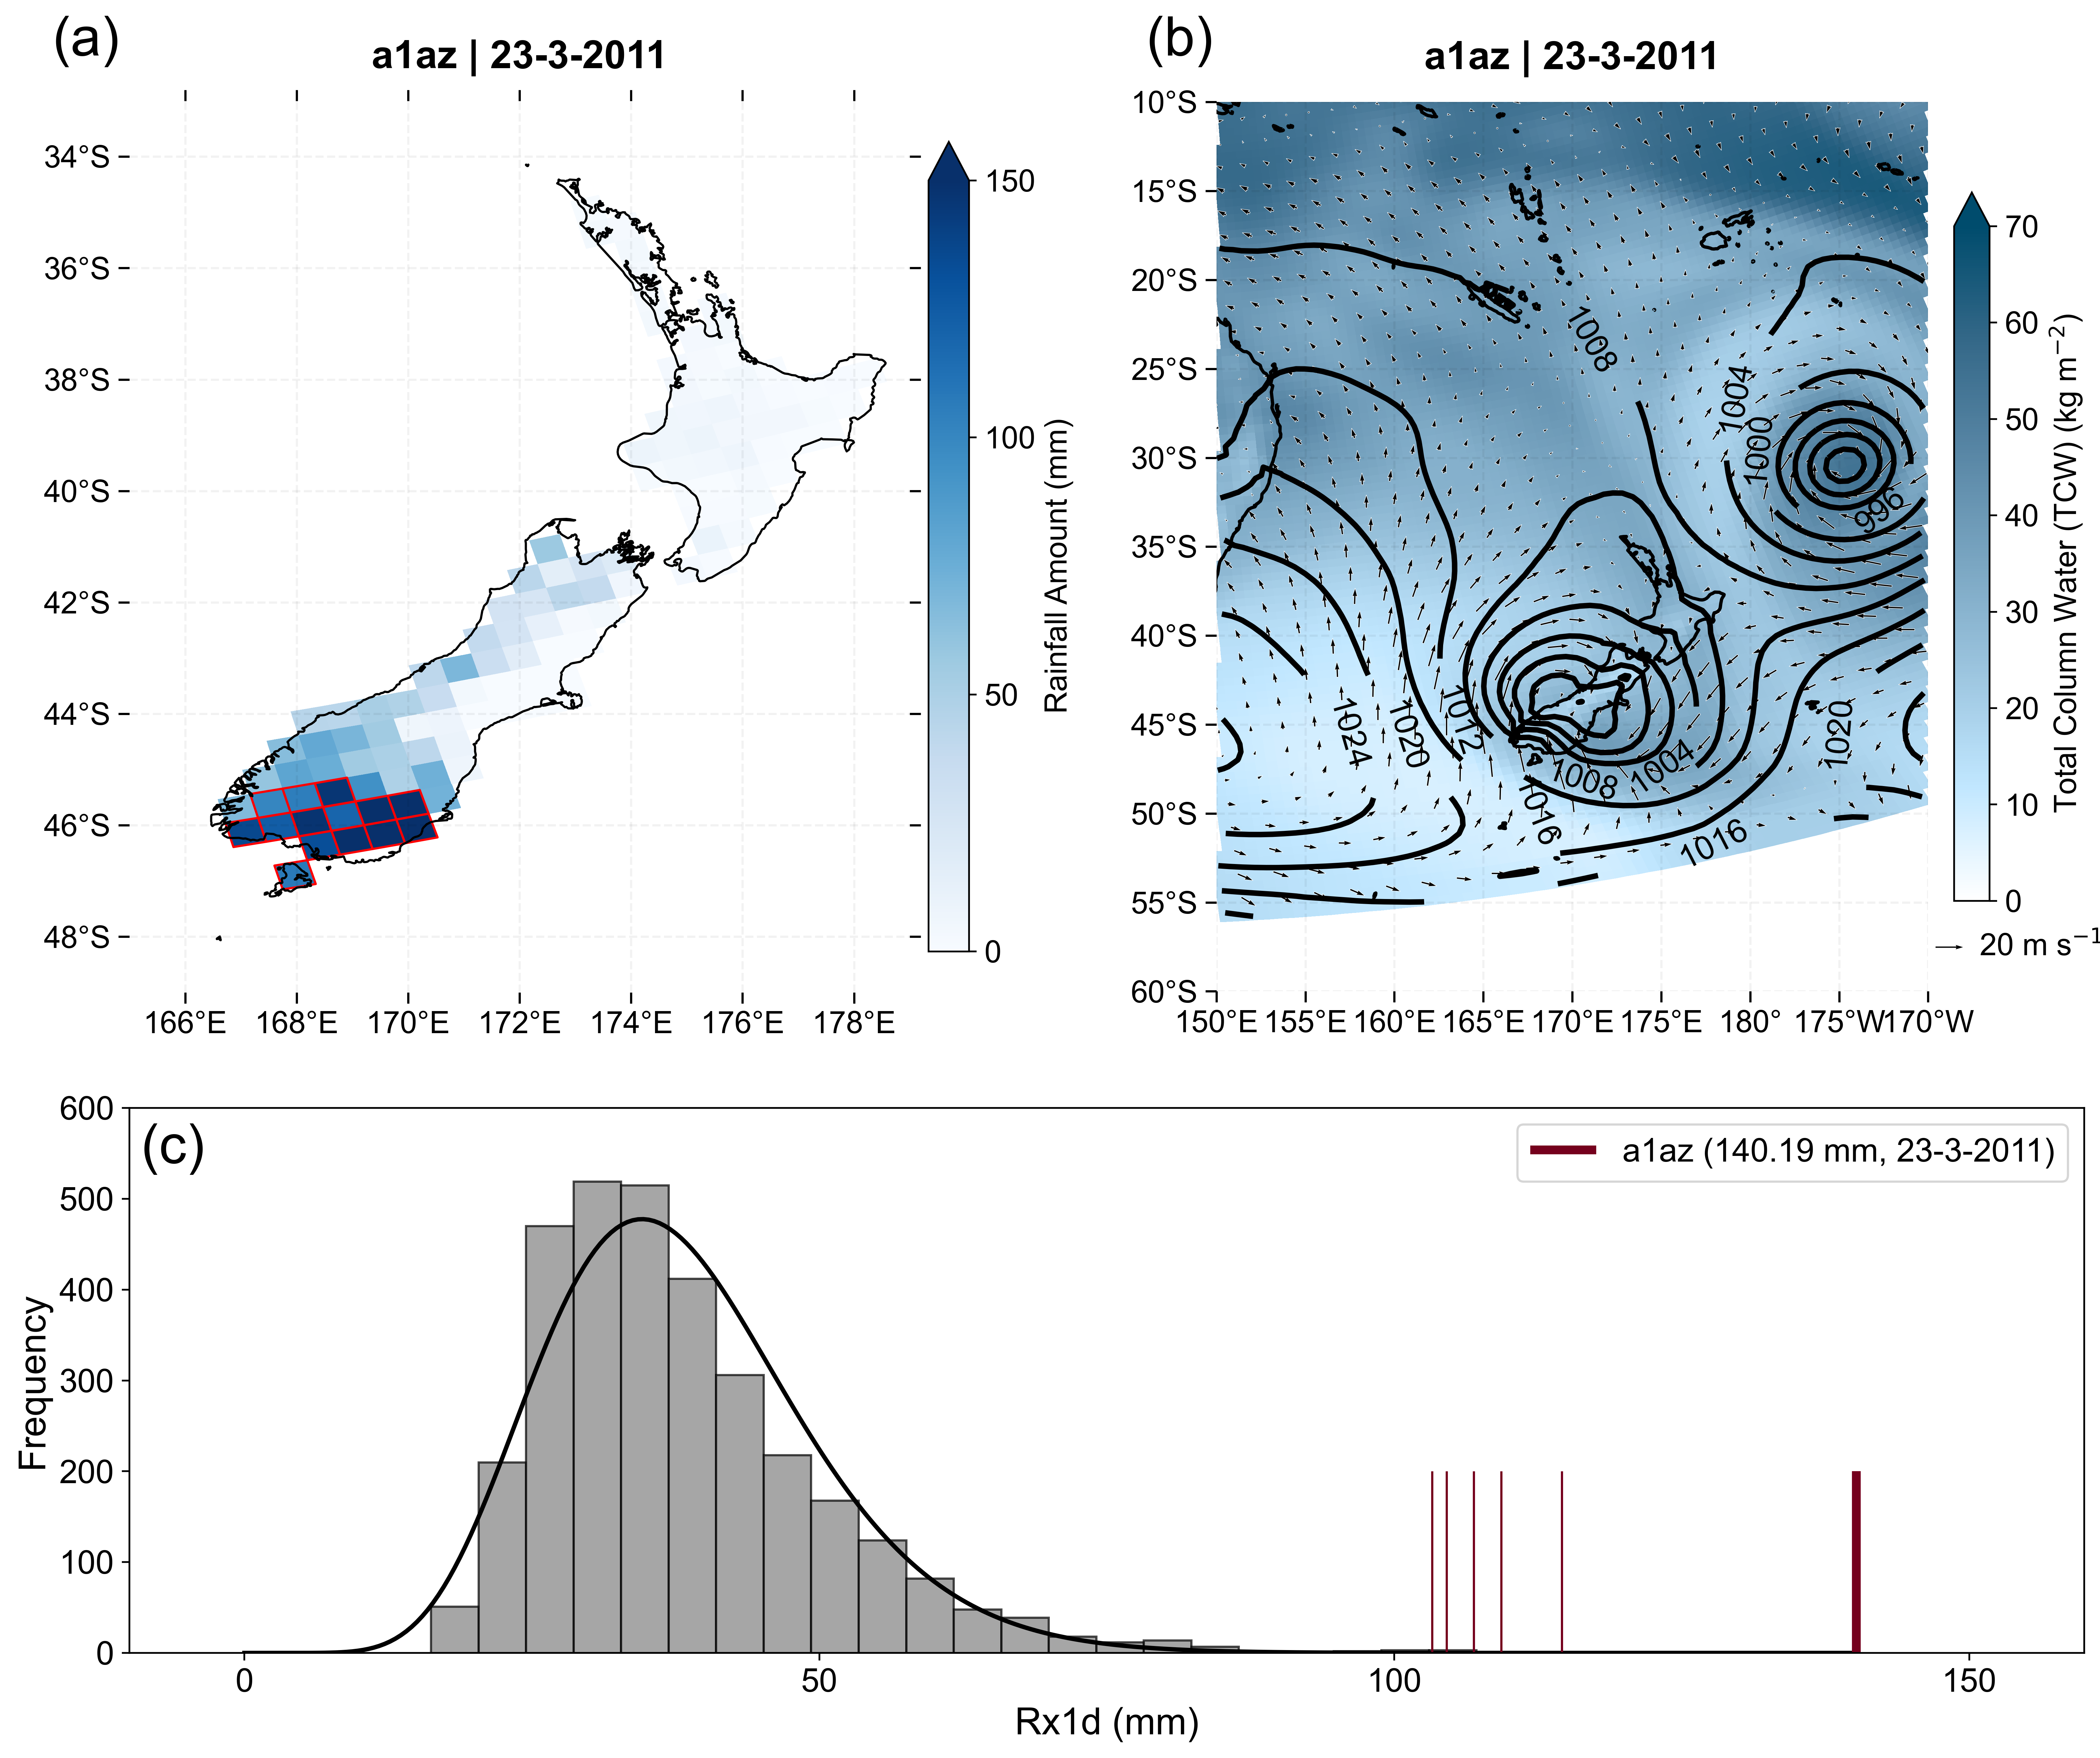

In [8]:
# ---------------------------------------------------------------
# Section 7: Create figure with three panels (a: rainfall map, b: synoptic map, c: histogram)
# ---------------------------------------------------------------

# Create figure with increased height for clearer subplot spacing
fig = plt.figure(figsize=(14, 12), dpi=500)

# Use GridSpec to control subplot layout and relative panel sizes (more space on the right)
gs = gridspec.GridSpec(2, 2, width_ratios=[0.52, 0.48], height_ratios=[0.65, 0.35])  # Adjusted for more space on the right



# ---------------------------------------------------------------
# Panel (a): Rainfall map
# ---------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())  # Top-left subplot

# Add title and subplot label
selected_simulated_date = day + '-' + month + '-' + year
ax1.set_title(selected_umid + ' | ' + selected_simulated_date, fontsize=18, pad=15, loc='center', weight='bold')
ax1.text(0.055, 0.935, '(a)', transform=ax1.figure.transFigure, fontsize=25, va='top', ha='left')

# Configure map gridlines and coastlines
setup_gridlines(ax1)

# Plot rainfall data with color mapping
plot_rainfall = ax1.pcolormesh(selected_rainfall.global_longitude0, selected_rainfall.global_latitude0, selected_rainfall, 
                               transform=ccrs.PlateCarree(), cmap="Blues", norm = mcolors.Normalize(vmin=0, vmax=150))

# Add colorbar for rainfall
cbar_rainfall = fig.colorbar(plot_rainfall, ax=ax1, orientation='vertical', extend='max', pad=0.02, shrink=0.8, ticks=np.arange(0, 160, 50))
cbar_rainfall.set_label('Rainfall Amount (mm)', fontsize=14)
cbar_rainfall.ax.tick_params(labelsize=14)

# Highlight grid cells exceeding the selected rainfall threshold
grid_cells_above_threshold = selected_rainfall >= select_rainfall_threshold # Define grid cells exceeding rainfall threshold
ax1.pcolor(selected_rainfall.global_longitude0, selected_rainfall.global_latitude0, np.where(grid_cells_above_threshold, 1, np.nan),
    transform=ccrs.PlateCarree(), facecolors='none', edgecolors="#ff0000", linewidths=1, alpha=1)

# Remove map frame
ax1.spines['geo'].set_visible(False)



# ---------------------------------------------------------------
# Panel (b): Synoptic map (MSLP, TCW, wind)
# ---------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))  # Top-right subplot

# Add title and subplot label
ax2.set_title(selected_umid + ' | ' + selected_simulated_date, fontsize=18, pad=15, loc='center', weight='bold')
ax2.text(0.55, 0.935, '(b)', transform=ax2.figure.transFigure, fontsize=25, va='top', ha='left')

# Plot mean sea-level pressure (MSLP) contours
plot_mslp = ax2.contour(selected_mslp.global_longitude0, selected_mslp.global_latitude0, selected_mslp, np.arange(900, 1101, 4), 
                        transform=ccrs.PlateCarree(), colors='black', linestyles='solid', linewidths=2.5)
ax2.clabel(plot_mslp, inline=True, fontsize=15, fmt='%1.0f', inline_spacing=20, colors='black')

# Plot total column water (TCW) with custom colormap
custom_cmap_tcw = mcolors.LinearSegmentedColormap.from_list("custom_tcw", ['white', '#c1e7ff', '#9dc6e0', '#7aa6c2', '#5886a5', '#346888', '#004c6d'], N=256)
plot_tcw = ax2.pcolormesh(selected_tcw.global_longitude0, selected_tcw.global_latitude0, selected_tcw, transform=ccrs.PlateCarree(), 
                          cmap=custom_cmap_tcw, norm=mcolors.Normalize(vmin=0, vmax=70), alpha=1)

# Add colorbar for TCW
cbar_tcw = fig.colorbar(plot_tcw, ax=ax2, orientation='vertical', extend='max', pad=0.03, shrink=0.7)
cbar_tcw.set_label('Total Column Water (TCW) (kg m$^{-2}$)', fontsize=14)
cbar_tcw.ax.tick_params(labelsize=14)

# Plot wind vectors, with adjusting arrow density for clarity
lon_for_plot_wind = selected_wind_u.global_longitude1[::3, ::3]
lat_for_plot_wind = selected_wind_u.global_latitude1[::3, ::3]
plot_u = selected_wind_u[::3, ::3]
plot_v = selected_wind_v[::3, ::3]
plot_wind = ax2.quiver(lon_for_plot_wind + 180, lat_for_plot_wind, plot_u, plot_v, transform=ccrs.PlateCarree(central_longitude=180), 
                       color='black', edgecolors='white', linewidth=0.2, scale=500)

# Add reference vector for wind speed
ax2.quiverkey(plot_wind, X=1.05, Y=0.05, U=20, label='20 m s$^{-1}$', labelpos='E', coordinates='axes', fontproperties={'size': 14})

# Add coastline
ax2.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.5)

# Configure map gridlines
setup_synoptic_gridlines(ax2)

# Remove map frame
ax2.spines['geo'].set_visible(False)



# ---------------------------------------------------------------
# Panel (c): Histogram of Rx1d with fitted Gamma distribution
# ---------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])  # This will span across the bottom row

# Extract Rx1d values for the selected grid cells
rx1d_data_of_specified_grid_cells = rx1d_of_specified_grid_cells_df[selected_umid]

# Plot histogram of Rx1d data
counts, bins, patches = ax3.hist(rx1d_data_of_specified_grid_cells, bins=30, color="gray", edgecolor="black", alpha=0.7)

# Fit Gamma distribution to Rx1d data for visualization
shape, loc, scale = stats.gamma.fit(rx1d_data_of_specified_grid_cells, floc=0)  # Force location to 0 for better fit
x_smooth = np.linspace(0, max(bins), 300)
y_smooth = stats.gamma.pdf(x_smooth, shape, loc=loc, scale=scale) * len(rx1d_data_of_specified_grid_cells) * np.diff(bins)[0]

# Plot fitted Gamma curve
ax3.plot(x_smooth, y_smooth, color='black', linewidth=2)

# Set axis labels, limits, and ticks
ax3.set_xlabel("Rx1d (mm)", fontsize=17)
ax3.set_ylabel("Frequency", fontsize=17)
ax3.set_ylim(0, 600)
ax3.set_xlim(-10, 160)
ax3.set_xticks(np.arange(0,160,50))
ax3.tick_params(axis='x', labelsize=15)  # For x-axis font size
ax3.tick_params(axis='y', labelsize=15)  # For y-axis font size

# Highlight maximum Rx1d value with a vertical line and legend
ax3.vlines(x=rx1d_data_of_specified_grid_cells.max(), ymin=0, ymax=200, color='#75001d', linestyle='-', linewidth=4, 
           label=selected_umid + ' (' + str(np.round(rx1d_data_of_specified_grid_cells.max(), 2)) + ' mm, ' + selected_simulated_date + ')')
ax3.legend(loc='upper right', fontsize=15)

# Highlight next 5 Rx1d events with thinner lines
for i in range (0, 5):
    top5_excluding_highest = rx1d_data_of_specified_grid_cells.sort_values().values[i-6]
    ax3.vlines(x=top5_excluding_highest, ymin=0, ymax=200, color='#75001d', linestyle='-', linewidth=1)

# Add subplot label
ax3.text(0.095, 0.35, '(c)', transform=ax3.figure.transFigure, fontsize=25, va='top', ha='left')

# Adjust layout and gridlines, and show figure
ax3.grid(color='None', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout(pad=2.0)
plt.show()
plt.close()